In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pyzbar.pyzbar as pyzbar

[]


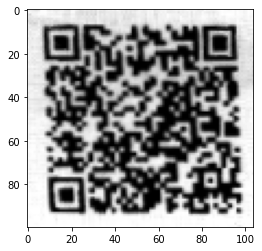

In [24]:
img = cv2.imread('qr/0007.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.resize(img, (0, 0), fx=2.5, fy=2.5)
barcodes=pyzbar.decode(img)
print(barcodes)
plt.imshow(img, cmap='gray')

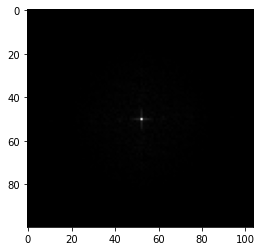

In [25]:
fft_img = np.fft.fft2(img)
r, c = img.shape
fft_img = np.fft.fftshift(fft_img)

show_img = np.abs(fft_img)
plt.imshow(show_img, cmap='gray')

In [26]:
D = np.zeros((201, 201))
for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        D[i, j] = np.sqrt((i-100)**2+(j-100)**2)
D[100, 100]=1e-3

[]


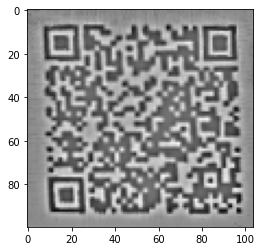

In [27]:
fft_img = np.fft.fft2(img)
r, c = img.shape
fft_img = np.fft.fftshift(fft_img)

D0, n = 10, 5
trunc_D = D[100-r//2:100-r//2+r, 100-c//2:100-c//2+c]
H = 1 / (1 + (D0/trunc_D)**2)
H[r//2, c//2]=1

filtered_img = H * fft_img
filtered_img = np.fft.ifft2(filtered_img)
filtered_img = np.abs(filtered_img)

filtered_img = np.around(np.abs(filtered_img)).astype(np.uint8)

barcodes=pyzbar.decode(filtered_img)
print(barcodes)
plt.imshow(filtered_img, cmap='gray')

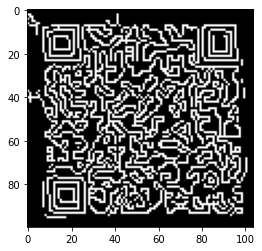

In [28]:
canny = cv2.Canny(filtered_img, 40, 150)
plt.imshow(canny, cmap='gray')

[]


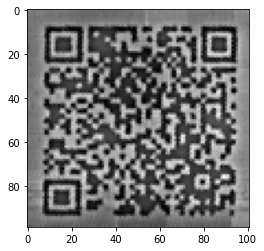

In [198]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
morphed = cv2.morphologyEx(filtered_img, cv2.MORPH_TOPHAT, kernel)

barcodes=pyzbar.decode(morphed)
print(barcodes)
plt.imshow(morphed, cmap='gray')

In [193]:
thrs, _ = cv2.threshold(filtered_img, 0, 255, cv2.THRESH_OTSU)

output2 = filtered_img.copy()
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        if output2[i][j] < thrs:
            output2[i][j] //= 3
        # else:
        #     output2[i][j] = min(int(output2[i][j]*1.5), 255)
barcodes=pyzbar.decode(output2)
print(thrs, barcodes)
plt.imshow(output2, cmap='gray')

IndexError: index 101 is out of bounds for axis 0 with size 101

[]


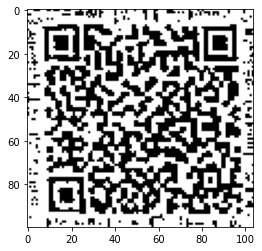

In [194]:
test = cv2.adaptiveThreshold(output, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5)
barcodes=pyzbar.decode(test)
print(barcodes)
plt.imshow(test, cmap='gray')

[]


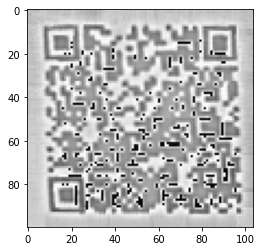

In [116]:
fft_img = np.fft.fft2(output)
r1, c1 = output.shape
fft_img = np.fft.fftshift(fft_img)

D0, n = 3, 5
trunc_D = D[100-r1//2:100-r1//2+r1, 100-c1//2:100-c1//2+c1]
H = 1 / (1 + (D0/trunc_D)**2)
H[r1//2, c1//2]=1

filtered_img = H * fft_img
filtered_img = np.fft.ifft2(filtered_img)
filtered_img = np.real(filtered_img)

filtered_img = np.around(np.abs(filtered_img)).astype(np.uint8)

barcodes=pyzbar.decode(filtered_img)
print(barcodes)
plt.imshow(filtered_img, cmap='gray')

分割线

[]


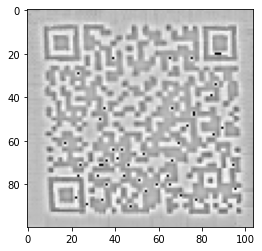

In [84]:
fft_img = np.fft.fft2(output)
r2, c2 = output.shape
fft_img = np.fft.fftshift(fft_img)

D0, n = 3, 5
trunc_D = D[100-r1//2:100-r1//2+r1, 100-c1//2:100-c1//2+c1]
H = 1 / (1 + (D0/trunc_D)**2)
H[r1//2, c1//2]=1

filtered_img = H * fft_img
filtered_img = np.fft.ifft2(filtered_img)
filtered_img = np.real(filtered_img)

filtered_img = np.around(np.abs(filtered_img)).astype(np.uint8)

barcodes=pyzbar.decode(filtered_img)
print(barcodes)
plt.imshow(filtered_img, cmap='gray')

In [ ]:
img = 255 - img
blur = cv2.medianBlur(img, 1)
plt.imshow(blur, cmap='gray')

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
plt.imshow(morphed, cmap='gray')

In [ ]:
output = 255 - cv2.subtract(img, morphed)
barcodes=pyzbar.decode(output)
print(barcodes)
plt.imshow(output, cmap='gray')

In [ ]:
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
# morph_img = cv2.morphologyEx(output, cv2.MORPH_OPEN, kernel)

# test = cv2.adaptiveThreshold(morph_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 2)
# plt.imshow(morph_img, cmap='gray')

In [ ]:
# canny = cv2.Canny(test, 40, 150)

# contour_img = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
# contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contour_img = cv2.drawContours(contour_img, contours, -1, (255, 0, 0), 1)

# plt.imshow(contour_img)

In [ ]:
# max_contour ,max_area = 0, 0
# for contour in contours:
#     tmp = cv2.contourArea(contour)
#     if tmp > max_area:
#         max_contour, max_area = contour, tmp
# print(max_contour.shape)
# max_contour = max_contour[::-1, :, :]

# # robustness：如果不是4怎么办   0.02来自于网络
# poly_contour = cv2.approxPolyDP(max_contour, 0.02 * cv2.arcLength(max_contour, True), True)

# points = poly_contour.squeeze()
# # assert(len(poly_contour) == 4)
# print(poly_contour)

In [ ]:
# c = np.cross(points[1]-points[0], points[2]-points[1])
# if c > 0:   # 修正为右旋标价
#     points = points[::-1, :]

# len1 = np.linalg.norm(points[0] - points[1])
# len2 = np.linalg.norm(points[1] - points[2])
# if len1 >= len2:    # 短边优先
#     points = np.roll(points, 1, axis=0)

# if points[0][0] > points[2][0]: # y值小的优先
#     points = np.roll(points, 2, axis=0)

# outer_x, outer_y = 10, 10
# shape_x, shape_y = 105, 105

# N = np.array([[outer_x, outer_y], [outer_x, shape_y - outer_y], 
#             [shape_x - outer_x, shape_y - outer_y], [shape_x - outer_x, outer_y]])
# mat = cv2.getPerspectiveTransform(points.astype(np.float32), N.astype(np.float32))
# output1 = cv2.warpPerspective(output, mat, (shape_x, shape_y), borderValue=255)
# plt.imshow(output1, cmap='gray')

In [ ]:
# output = output1

laplacian = cv2.Laplacian(output, -1)
new_img =cv2.subtract(output, laplacian)
barcodes=pyzbar.decode(new_img)
print(barcodes)
plt.imshow(new_img, cmap='gray')

output = new_img

In [ ]:
test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
barcodes=pyzbar.decode(test)
print(barcodes)
plt.imshow(test, cmap='gray')

255 []


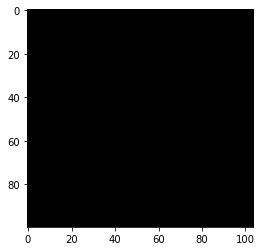

In [62]:
new_img = filtered_img

for i in range(127, 256):  #粗暴的阈值处理（可能先通过某种算法调整对比度）
    _, output2 = cv2.threshold(new_img, i, 255, cv2.THRESH_BINARY)
    barcodes=pyzbar.decode(output2)
    if len(barcodes) != 0:
        break
# _, output2 = cv2.threshold(new_img, 0, 255, cv2.THRESH_OTSU)

print(i, barcodes)
plt.imshow(output2, cmap='gray')

### 一个简单的汇总

In [75]:
def fix_img(old_img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
    morph_img = cv2.morphologyEx(old_img, cv2.MORPH_OPEN, kernel)

    test = cv2.adaptiveThreshold(morph_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 2)
    canny = cv2.Canny(test, 40, 150)
    contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_contour ,max_area = 0, 0
    for contour in contours:
        tmp = cv2.contourArea(contour)
        if tmp > max_area:
            max_contour, max_area = contour, tmp
    
    max_contour = max_contour[::-1, :, :]
    poly_contour = cv2.approxPolyDP(max_contour, 0.02 * cv2.arcLength(max_contour, True), True)
    points = poly_contour.squeeze()
    if len(poly_contour) != 4:
        return None

    c = np.cross(points[1]-points[0], points[2]-points[1])
    if c > 0:   # 修正为右旋标价
        points = points[::-1, :]

    len1 = np.linalg.norm(points[0] - points[1])
    len2 = np.linalg.norm(points[1] - points[2])
    if len1 >= len2:    # 短边优先
        points = np.roll(points, 1, axis=0)

    if points[0][0] > points[2][0]: # y值小的优先
        points = np.roll(points, 2, axis=0)

    outer_x, outer_y = 10, 10
    shape_x, shape_y = 105, 105

    N = np.array([[outer_x, outer_y], [outer_x, shape_y - outer_y], 
                [shape_x - outer_x, shape_y - outer_y], [shape_x - outer_x, outer_y]])
    mat = cv2.getPerspectiveTransform(points.astype(np.float32), N.astype(np.float32))
    return cv2.warpPerspective(output, mat, (shape_x, shape_y), borderValue=255)


In [76]:
def att2(img):
    fft_img = np.fft.fft2(img)
    r, c = img.shape
    fft_img = np.fft.fftshift(fft_img)

    D0, n = 10, 5
    trunc_D = D[100-r//2:100-r//2+r, 100-c//2:100-c//2+c]
    H = 1 / (1 + (D0/trunc_D)**2)
    H[r//2, c//2]=1

    filtered_img = H * fft_img
    filtered_img = np.fft.ifft2(filtered_img)
    filtered_img = np.real(filtered_img)

    filtered_img = np.around(np.abs(filtered_img)).astype(np.uint8)

    barcodes=pyzbar.decode(filtered_img)
    if len(barcodes) > 0:
        return 5, barcodes[0].data.decode('utf-8')
    
    test = cv2.adaptiveThreshold(filtered_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
    barcodes=pyzbar.decode(test)
    if len(barcodes) > 0:
        return 5, barcodes[0].data.decode('utf-8')
    test = cv2.adaptiveThreshold(filtered_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
    barcodes=pyzbar.decode(test)
    if len(barcodes) > 0:
        return 5, barcodes[0].data.decode('utf-8')

    for i in range(127, 256):  #粗暴的阈值处理（可能先通过某种算法调整对比度）
        _, output2 = cv2.threshold(filtered_img, i, 255, cv2.THRESH_BINARY)
        barcodes=pyzbar.decode(output2)
        if len(barcodes) != 0:
            return 5, barcodes[0].data.decode('utf-8')
    return -1, ''

In [2]:
def recog_qr(img, not_continue=False):
    barcodes=pyzbar.decode(img)
    if len(barcodes) > 0:
        return 0, barcodes[0].data.decode('utf-8')
    
    img = 255 - img
    blur = cv2.medianBlur(img, 5)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    output = 255 - cv2.subtract(img, morphed)
    barcodes=pyzbar.decode(output)
    if len(barcodes) > 0:
        return 1, barcodes[0].data.decode('utf-8')
    

    for att in range(3):
        laplacian = cv2.Laplacian(output, -1)
        new_img =cv2.subtract(output, laplacian)
        barcodes=pyzbar.decode(new_img)
        if len(barcodes) > 0:
            return 2, barcodes[0].data.decode('utf-8')
        
        test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
        barcodes=pyzbar.decode(test)
        if len(barcodes) > 0:
            return 3, barcodes[0].data.decode('utf-8')
        test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
        barcodes=pyzbar.decode(test)
        if len(barcodes) > 0:
            return 3, barcodes[0].data.decode('utf-8')
        
        if not_continue:
            return -1, ''

        for i in range(127, 256):  #粗暴的阈值处理（可能先通过某种算法调整对比度）
            _, output2 = cv2.threshold(new_img, i, 255, cv2.THRESH_BINARY)
            barcodes=pyzbar.decode(output2)
            if len(barcodes) != 0:
                return 4, barcodes[0].data.decode('utf-8')
        if not_continue:
            return -1, ''
        else:
            img = cv2.resize(img, (0, 0), fx=2.5, fy=2.5)
            return recog_qr(img, True)
            
            # output = fix_img(new_img)
            # if output is None:
            #     return att2(img)
            # else:
            #     return att2(output)
    # return att2(img)
    

In [7]:
def process_qr(img):
    status, content = recog_qr(img, False)
    if status != -1:
        return status, content
    
    for rate in np.arange(0.8, 1, 0.01):
        for divide in np.arange(0.25, 0.5, 0.05):
            r, c = img.shape
            crop_x = int(c * divide)
            left_img = img[:, :crop_x]
            right_img = img[:, crop_x:]
            rl, cl = left_img.shape
            left_img2 = cv2.resize(left_img, (int(cl*rate),  rl))
            fit_img = np.hstack([left_img2, right_img])

            status, content = recog_qr(fit_img, True)
            if status != -1:
                return status, content
    return -1, ''


In [14]:
input_path = 'qr'
output_file = 'predictions.txt'
counter = [0, 0, 0, 0, 0, 0]

D = np.zeros((201, 201))
for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        D[i, j] = np.sqrt((i-100)**2+(j-100)**2)
D[100, 100]=1e-3

with open(output_file, 'w') as f:
    for file_name in tqdm(os.listdir(input_path)):
        img = cv2.imread(os.path.join(input_path, file_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # img = cv2.resize(img, (0, 0), fx=2.5, fy=2.5)
        status, result = process_qr(img)
        f.write('{} {}\n'.format(file_name, result))
        if status != -1:
            counter[status] += 1

total = sum(counter)
print()
print('Sum*', 'Base', 'T-hat', 'lapla', 'athrs', 'thrs', 'att2', sep='\t')
print(total, *counter, sep='\t')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.42it/s]
Sum*	Base	T-hat	lapla	athrs	thrs	att2
78	43	9	16	10	0	0

